# May Mobility (Data Scientist)

## Route?

Rough Idea of how the route looks   

I don't know if this is the actual route.

As I comb through more of the data, I'll get a better understanding of what order the stops are.

I just ploted the lat/lon in order from the appendix to give myself a visual aid.

![rough_image](resources/pics/rough_idea_route.png)


Point of Interest (PoI) Table

| Stop       | Description                      | Latitude | Longitude |
|:-----------|:--------------------------------:|----------|-----------|
| Bus        | Bus stop on a major transit line | 39.77285 | -86.16168 |
| Dentist    | School of Dentistry              | 39.77467 | -86.17895 |
| Doctor     | Pediatrician’s office            | 39.77926 | -86.17496 |
| Admin      | Administrative building          | 39.77459 | -86.17433 |
| Hospital   | Campus hospital                  | 39.77567 | -86.17557 |
| Lime       | Bus stop on campus               | 39.77473 | -86.18376 |
| Parking    | Campus parking lot               | 39.77882 | -86.18121 |
| School     | School of Art and Design         | 39.77148 | -86.17148 |
| University | University lecture hall          | 39.77271 | -86.17575 |


# Data Wrangling

## Read Data and Import modules

In [315]:
import pandas as pd
import numpy as np
import datetime
# QoL for viewing df output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

# read-in *.csv files
pickups_df   = pd.read_csv("resources/csv/Data_Science_pickups.csv", na_values = np.nan)
ridership_df = pd.read_csv("resources/csv/Data_Science_site_ridership.csv", na_values = np.nan)

## Quick Check of DataFrames

In [316]:
# get a feel of what the pickups dataframe looks like
pickups_df.head()

,row_id,timestamp,pickup,dropoff,stop,vehicle,time,date,name
0,1,2021-11-01 07:10:54,1,0,Bus,Marble,07:00:00,2021-11-01,ES
1,2,2021-11-01 07:51:13,1,0,Bus,Marble,07:50:00,2021-11-01,ES
2,3,2021-11-01 08:02:13,1,0,Lime,Marble,08:01:00,2021-11-01,ES
3,4,2021-11-01 08:41:16,1,0,Doctor,Motto,08:41:00,2021-11-01,CM
4,5,2021-11-01 09:24:10,1,0,Bus,Myao,09:22:00,2021-11-01,CM


## Inspect and convert data types

### Pickups DataFrame

In [317]:
# pickups data frame: data types
pickups_df.dtypes

row_id        int64
timestamp    object
pickup        int64
dropoff       int64
stop         object
vehicle      object
time         object
date         object
name         object
dtype: object

In [318]:
# pickups data frame: check for nulls and count
pickups_df.isnull().sum()

row_id       0
timestamp    0
pickup       0
dropoff      0
stop         0
vehicle      0
time         0
date         0
name         0
dtype: int64

In [319]:
# Update Data types in pickups_df

# timestamp    object
pickups_df["timestamp"] = pd.to_datetime(pickups_df["timestamp"], format="%Y-%m-%d %H:%M:%S")

# stop         object
pickups_df["stop"] = pickups_df["stop"].astype("category")

# vehicle      object
pickups_df["vehicle"] = pickups_df["vehicle"].astype("category")

# date         object
pickups_df["date"] = pd.to_datetime(pickups_df["date"], format="%Y-%m-%d")

# name         object
pickups_df["name"] = pickups_df["name"].astype("category")

pickups_df.dtypes

row_id                int64
timestamp    datetime64[ns]
pickup                int64
dropoff               int64
stop               category
vehicle            category
time                 object
date         datetime64[ns]
name               category
dtype: object

#### Stats

In [388]:
# check record dates
pickup_timestamp_min = pickups_df["timestamp"].min()
pickup_timestamp_max = pickups_df["timestamp"].max()

print(f'The range of dates: {pickup_timestamp_min:%b %d %Y} to {pickup_timestamp_max:%b %d %Y}.')

The range of dates: Nov 01 2021 to Nov 12 2021.


In [389]:
# records per vehicle 
pickups_df["timestamp"].groupby(pickups_df["vehicle"]).count()

vehicle
Marble    91
Mette     26
Moon      58
Motto     99
Myao      89
Name: timestamp, dtype: int64

In [396]:
pickups_df["timestamp"].groupby(pickups_df["name"]).count()

name
CM    138
DL     11
DN      7
ES      8
JR    127
KP      6
MV      7
SR      5
TL     26
VG     28
Name: timestamp, dtype: int64

In [397]:
pickups_df["timestamp"].groupby(pickups_df["stop"]).count()

stop
Admin         35
Bus           97
Dentist       19
Doctor        44
Hospital      20
Lime          95
Parking        1
School        14
University    38
Name: timestamp, dtype: int64

### Ridership DataFrame

In [398]:
# get a feel of what the pickups dataframe looks like
ridership_df.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,day,hour,name
0,2021-06-03 13:08:10,1.00,0.00,Bus,Motto,13:05:00,2021-06-03,Thursday,13,JR
1,2021-06-03 13:31:41,0.00,1.00,Bus,Motto,13:31:43,2021-06-03,Thursday,13,JR
2,2021-06-04 11:06:02,1.00,0.00,School,Motto,11:03:00,2021-06-04,Friday,11,CM
3,2021-06-04 11:07:48,0.00,1.00,Bus,Motto,11:07:00,2021-06-04,Friday,11,CM
4,2021-06-04 12:43:54,1.00,0.00,Bus,Motto,12:40:00,2021-06-04,Friday,12,MN


In [399]:
# ridership data frame: data types
ridership_df.dtypes

timestamp    datetime64[ns]
pickup              float64
dropoff             float64
stop               category
vehicle            category
time                 object
date         datetime64[ns]
day                category
hour               category
name               category
dtype: object

##### Null Check

In [322]:
# ridership data frame: check for nulls and count
ridership_df.isnull().sum()

timestamp     0
pickup       12
dropoff      15
stop          0
vehicle       0
time          0
date          0
name          0
dtype: int64

In [323]:
# Data type changes in ridership_df
# timestamp     object
ridership_df["timestamp"] = pd.to_datetime(ridership_df["timestamp"], format="%Y-%m-%d %H:%M:%S")

# # pickup       float64 
# Should be int64
# ridership_df["pickup"] = ridership_df["pickup"]

# # dropoff      float64
# Should be int64
# ridership_df["dropoff"] = ridership_df["dropoff"]

# stop          object
ridership_df["stop"] = ridership_df["stop"].astype("category")

# vehicle       object
ridership_df["vehicle"] = ridership_df["vehicle"].astype("category")

# date          object
ridership_df["date"] = pd.to_datetime(ridership_df["date"], format="%Y-%m-%d")

# name          object
ridership_df["name"] = ridership_df["name"].astype("category")

ridership_df.dtypes

timestamp    datetime64[ns]
pickup              float64
dropoff             float64
stop               category
vehicle            category
time                 object
date         datetime64[ns]
name               category
dtype: object

##### Days and Hour

In [324]:
# add days of the week for QoL
day_number = ridership_df["timestamp"].dt.weekday
day_name   = ridership_df["timestamp"].dt.day_name()
weekend    = day_number > 5 # is weekend?

if ~any(weekend):
    print(f"since any(weekend) = {any(weekend)}, There are no rides on the weekends.")
else:
    print(f"since any(weekend) = {any(weekend)}, There are rides on the weekends.")

# nice to check side-by-side, don't really need this next line.
op_days = pd.DataFrame({"day_num":day_number,"day":day_name,"is_weekday":weekend}) 

ridership_df.insert(ridership_df.columns.get_loc("name"),"day",ridership_df["timestamp"].dt.day_name().astype("category"))

since any(weekend) = False, There are no rides on the weekends.


In [325]:
# add hour for QoL
ridership_df.insert(ridership_df.columns.get_loc("name"),"hour",ridership_df["timestamp"].dt.hour.astype("category"))

ridership_df.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,day,hour,name
0,2021-06-03 13:08:10,1.00,0.00,Bus,Motto,13:05:00,2021-06-03,Thursday,13,JR
1,2021-06-03 13:31:41,0.00,1.00,Bus,Motto,13:31:43,2021-06-03,Thursday,13,JR
2,2021-06-04 11:06:02,1.00,0.00,School,Motto,11:03:00,2021-06-04,Friday,11,CM
3,2021-06-04 11:07:48,0.00,1.00,Bus,Motto,11:07:00,2021-06-04,Friday,11,CM
4,2021-06-04 12:43:54,1.00,0.00,Bus,Motto,12:40:00,2021-06-04,Friday,12,MN


In [355]:
# days of the week stats
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # re-cat for starting on monday....
ridership_stats_days = ridership_df[["pickup","dropoff"]].groupby(ridership_df["timestamp"].dt.day_name()).describe().reindex(days_of_the_week).dropna()
ridership_stats_days

pickup                                     dropoff                                   
             count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
timestamp                                                                                        
Monday      716.00 0.60 0.66 0.00 0.00 1.00 1.00 3.00   715.00 0.61 0.65 0.00 0.00 1.00 1.00 3.00
Tuesday     817.00 0.61 0.70 0.00 0.00 1.00 1.00 4.00   815.00 0.61 0.69 0.00 0.00 1.00 1.00 4.00
Wednesday   874.00 0.63 0.79 0.00 0.00 1.00 1.00 8.00   874.00 0.62 0.77 0.00 0.00 1.00 1.00 8.00
Thursday  1,003.00 0.62 0.71 0.00 0.00 1.00 1.00 3.00 1,003.00 0.62 0.70 0.00 0.00 1.00 1.00 3.00
Friday      930.00 0.64 0.75 0.00 0.00 1.00 1.00 4.00   930.00 0.65 0.73 0.00 0.00 1.00 1.00 3.00

#### Null Fixing

In [327]:
# inspect missing data from pickups
null_ridership_pickup = ridership_df[ridership_df["pickup"].isnull()]
null_ridership_pickup

,timestamp,pickup,dropoff,stop,vehicle,time,date,day,hour,name
79,2021-06-17 14:09:37,NaN,1.00,Hospital,Mette,14:06:00,2021-06-17,Thursday,14,MV
81,2021-06-17 16:52:03,NaN,1.00,Doctor,Motto,16:51:00,2021-06-17,Thursday,16,JR
83,2021-06-17 20:25:00,NaN,1.00,Bus,Mette,17:03:00,2021-06-17,Thursday,20,JR
85,2021-06-18 11:23:45,NaN,1.00,Parking,Myao,11:16:00,2021-06-18,Friday,11,CM
87,2021-06-18 14:16:28,NaN,1.00,School,Mette,14:16:00,2021-06-18,Friday,14,MN
89,2021-06-18 17:08:13,NaN,1.00,University,Motto,17:07:00,2021-06-18,Friday,17,JR
91,2021-06-21 11:50:34,NaN,1.00,University,Myao,11:49:00,2021-06-21,Monday,11,CM
93,2021-06-21 11:51:33,NaN,1.00,Bus,Mette,09:15:00,2021-06-21,Monday,11,CM
95,2021-06-21 11:52:30,NaN,1.00,Bus,Mette,09:39:00,2021-06-21,Monday,11,CM
97,2021-06-21 11:53:31,NaN,1.00,Doctor,Myao,10:33:00,2021-06-21,Monday,11,CM


In [328]:
# inspect missing data from pickups
null_ridership_dropoff = ridership_df[ridership_df["dropoff"].isnull()]
null_ridership_dropoff

,timestamp,pickup,dropoff,stop,vehicle,time,date,day,hour,name
78,2021-06-17 14:02:53,1.00,NaN,Lime,Mette,14:00:00,2021-06-17,Thursday,14,MV
80,2021-06-17 16:49:04,1.00,NaN,Bus,Motto,16:40:00,2021-06-17,Thursday,16,JR
82,2021-06-17 16:53:10,1.00,NaN,Doctor,Mette,16:52:00,2021-06-17,Thursday,16,JR
84,2021-06-18 11:05:49,1.00,NaN,Bus,Myao,11:05:00,2021-06-18,Friday,11,CM
86,2021-06-18 14:12:59,1.00,NaN,Lime,Mette,14:10:00,2021-06-18,Friday,14,MN
88,2021-06-18 17:05:47,1.00,NaN,Doctor,Motto,17:04:00,2021-06-18,Friday,17,JR
90,2021-06-21 11:26:12,1.00,NaN,University,Myao,11:25:00,2021-06-21,Monday,11,CM
92,2021-06-21 11:51:08,1.00,NaN,Lime,Mette,08:56:00,2021-06-21,Monday,11,CM
94,2021-06-21 11:52:02,1.00,NaN,Doctor,Mette,09:29:00,2021-06-21,Monday,11,CM
96,2021-06-21 11:53:04,1.00,NaN,Bus,Myao,10:21:00,2021-06-21,Monday,11,CM


#### Error Fixing

In [329]:
# find data that shows pickup and/or dropoffs > 4
entry_error_ridership_df = ridership_df[(ridership_df[["pickup","dropoff"]] > 4).any(axis=1)]
entry_error_ridership_df

,timestamp,pickup,dropoff,stop,vehicle,time,date,day,hour,name
346,2021-07-14 16:45:21,8.00,0.00,Parking,Myao,16:44:00,2021-07-14,Wednesday,16,LA
348,2021-07-14 16:58:55,0.00,8.00,Admin,Myao,16:54:00,2021-07-14,Wednesday,16,LA
456,2021-07-21 14:18:18,8.00,0.00,Admin,Mette,14:18:00,2021-07-21,Wednesday,14,CM
457,2021-07-21 14:19:58,0.00,8.00,University,Mette,14:19:00,2021-07-21,Wednesday,14,CM


In [330]:
# input errors per person
entry_error = entry_error_ridership_df["name"].groupby(entry_error_ridership_df["name"]).count()
entry_error[entry_error > 0]

name
CM    2
LA    2
Name: name, dtype: int64

#### Stats

In [331]:
# display data analytics of errors/nulls/missing

# investigate nulls from earlier
# 
# pickup       12
# dropoff      15

total_records = ridership_df.shape[0] # total records

null_pickup_count  = ridership_df["pickup"].isnull().sum() # null count pickup
null_dropoff_count = ridership_df["dropoff"].isnull().sum() # null count dropoff
total_null_count   = null_pickup_count + null_dropoff_count # sum of null count

entry_error_count  = entry_error_ridership_df.shape[0] # error entries
total_error_count  = total_null_count + entry_error_count # grand total erros

print(f"Missing pickup data:  {null_pickup_count:3.0f} out of {total_records} records, {null_pickup_count/total_records:.2%}.")
print(f"Missing dropoff data: {null_dropoff_count:3.0f} out of {total_records} records, {null_dropoff_count/total_records:.2%}.")
print(f"total null data:      {total_null_count:3.0f} out of {total_records} records, {total_null_count/total_records:.2%}.")
print(f"Entry error data:     {entry_error_count:3.0f} out of {total_records} records, {entry_error_count/total_records:.2%}.")
print(f"Total errors is:      {total_error_count:3.0f} out of {total_records} records, {total_error_count/total_records:.2%}.")

Missing pickup data:   12 out of 4352 records, 0.28%.
Missing dropoff data:  15 out of 4352 records, 0.34%.
total null data:       27 out of 4352 records, 0.62%.
Entry error data:       4 out of 4352 records, 0.09%.
Total errors is:       31 out of 4352 records, 0.71%.


In [332]:
# investigate errors/nulls/missing data.
record_counts_per = ridership_df["name"].value_counts()
total_null_per =  ridership_df[["pickup","dropoff"]].isnull().groupby(ridership_df["name"]).sum().sum(axis=1)
total_errors_per = total_null_per + entry_error
percent_error_per = total_errors_per/record_counts_per

print(f"Total errors or missing data in ridership_df is {total_errors_per.sum()}.")

errors_df = pd.DataFrame({"percent_error":percent_error_per,
                          "errors":total_errors_per,
                          "records":record_counts_per})

errors_df.loc[:, "percent_error"] = errors_df["percent_error"].map('{:.2%}'.format)
errors_df[errors_df["errors"] != 0].sort_values("records",ascending=False)

Total errors or missing data in ridership_df is 31.


,percent_error,errors,records
JR,0.39%,6,1557
CM,1.20%,18,1497
MV,4.17%,2,48
LA,6.06%,2,33
MN,25.00%,2,8
HK,25.00%,1,4


In [333]:
# assume missing values are suppposed to be zero
# because most likely google forms wasnt defaulting to zero. 
# On the time period of Jun 17 to Jun 22

null_idx = ridership_df[["pickup","dropoff"]].isnull().any(axis=1)
null_timestamp_min = ridership_df[null_idx]["timestamp"].min()
null_timestamp_max = ridership_df[null_idx]["timestamp"].max()

print(f'The messed-up days range, could include from: {null_timestamp_min:%b %d %Y} to {null_timestamp_max:%b %d %Y}.')

The messed-up days range, could include from: Jun 17 2021 to Jun 22 2021.


In [334]:
# check to see if there is any simultaneous pickups and dropoffs
# subset removing NaN's
NaN_df = ridership_df[~null_idx]

# sanity check!
print(f"OG record count: {total_records}")
print(f"Reduced record count: {NaN_df.shape[0]}")
print(f"Difference: {total_records - NaN_df.shape[0]}")

sim_check = NaN_df[["pickup","dropoff"]].astype(bool)
and_check = sim_check["pickup"] & sim_check["dropoff"]

OG record count: 4352
Reduced record count: 4325
Difference: 27


In [ ]:
sim_ridership_df = ridership_df.iloc[sim_check[and_check].index]
sim_ridership_df

In [358]:
sim_count = sim_ridership_df.shape[0] # simultaneous records

print(f"Freq of both pickup and dropoff: {sim_count} out of {total_records}, {sim_count/total_records:.2%}")

# which days?
sim_ridership_df[["pickup"]].groupby(sim_ridership_df["timestamp"].dt.day_name()).count().rename(columns={"pickup":"freq"}).reindex(days_of_the_week).dropna()

Freq of both pickup and dropoff: 74 out of 4352, 1.70%


,freq
timestamp,
Monday,18.00
Tuesday,13.00
Wednesday,11.00
Thursday,19.00
Friday,13.00


In [376]:
sim_ridership_df["pickup"].groupby(sim_ridership_df["timestamp"].dt.hour).count().rename(columns={"pickup":"freq"})

,freq
timestamp,
8,3
10,4
11,5
12,7
13,8
14,14
15,4
16,17
17,4


In [384]:
ridership_df["timestamp"].groupby(ridership_df["vehicle"]).count()

vehicle
Marble     821
Mette      669
Moon       950
Motto      892
Myao      1020
Name: timestamp, dtype: int64

In [337]:
# remove error inputs
ridership_df_clean = ridership_df.drop(entry_error_ridership_df.index)

# replace NaN with zeros
# because only 74 out of 4352, 1.70% of records contain duplicates
ridership_df_clean[["pickup","dropoff"]] = ridership_df[["pickup","dropoff"]].fillna(value=0,)
ridership_df_clean

# check nulls
ridership_df_clean.isnull().sum()

timestamp    0
pickup       0
dropoff      0
stop         0
vehicle      0
time         0
date         0
day          0
hour         0
name         0
dtype: int64

In [385]:
# finally convert pickup and dropoff to int64
ridership_df_clean["pickup"]  = ridership_df_clean["pickup"].astype("int64")
ridership_df_clean["dropoff"] = ridership_df_clean["dropoff"].astype("int64")

# cleaned data
ridership_df_clean.dtypes

timestamp    datetime64[ns]
pickup                int64
dropoff               int64
stop               category
vehicle            category
time                 object
date         datetime64[ns]
day                category
hour               category
name               category
dtype: object

In [339]:
# first five lines of cleaned ridership data
ridership_df_clean.head()

,timestamp,pickup,dropoff,stop,vehicle,time,date,day,hour,name
0,2021-06-03 13:08:10,1,0,Bus,Motto,13:05:00,2021-06-03,Thursday,13,JR
1,2021-06-03 13:31:41,0,1,Bus,Motto,13:31:43,2021-06-03,Thursday,13,JR
2,2021-06-04 11:06:02,1,0,School,Motto,11:03:00,2021-06-04,Friday,11,CM
3,2021-06-04 11:07:48,0,1,Bus,Motto,11:07:00,2021-06-04,Friday,11,CM
4,2021-06-04 12:43:54,1,0,Bus,Motto,12:40:00,2021-06-04,Friday,12,MN


In [340]:
# Note : Time should be bound from 7am to 7pm.

# group by hour
per_hour = ridership_df_clean.groupby(ridership_df_clean["timestamp"].dt.hour).sum(numeric_only=True)

# Check for rides outside the bounds of 7am - 7pm
before_seven_am = per_hour.index < 7
after_seven_pm  = per_hour.index > 19

# collect data from before operating hours
pickup_before   = per_hour[before_seven_am]["pickup"].sum().sum()
dropoff_before  = per_hour[before_seven_am]["dropoff"].sum().sum()
total_before    = pickup_before + dropoff_before

# collect data from after operating hours
pickup_after    = per_hour[after_seven_pm]["pickup"].sum().sum()
dropoff_after   = per_hour[after_seven_pm]["dropoff"].sum().sum()
total_after     = pickup_after + dropoff_after

# print insights
print(f'A total of {total_before:2.0f} entries recorded before 7am: {dropoff_before} pickups and {pickup_before} dropoffs')
print(f'A total of {total_after:2.0f} entries recorded after  7pm: {pickup_after} pickups and {dropoff_after} dropoffs')

# nice table
per_hour

A total of 10 entries recorded before 7am: 3 pickups and 7 dropoffs
A total of  1 entries recorded after  7pm: 0 pickups and 1 dropoffs


,pickup,dropoff
timestamp,,
6,7,3
7,105,96
8,208,203
9,177,173
10,201,189
11,291,280
12,202,220
13,239,230
14,269,262


#### More Stats Checkin

In [341]:
ridership_df_clean.groupby(ridership_df_clean["day"]).describe()

pickup                                     dropoff                                   
             count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
day                                                                                              
Friday      933.00 0.64 0.75 0.00 0.00 0.00 1.00 4.00   933.00 0.65 0.73 0.00 0.00 1.00 1.00 3.00
Monday      722.00 0.60 0.66 0.00 0.00 1.00 1.00 3.00   722.00 0.60 0.65 0.00 0.00 1.00 1.00 3.00
Thursday  1,006.00 0.62 0.71 0.00 0.00 1.00 1.00 3.00 1,006.00 0.62 0.70 0.00 0.00 1.00 1.00 3.00
Tuesday     817.00 0.61 0.70 0.00 0.00 1.00 1.00 4.00   817.00 0.61 0.69 0.00 0.00 1.00 1.00 4.00
Wednesday   870.00 0.61 0.70 0.00 0.00 1.00 1.00 3.00   870.00 0.61 0.69 0.00 0.00 1.00 1.00 3.00

In [342]:
ridership_df_clean.groupby(ridership_df_clean["stop"]).describe()

pickup                                     dropoff                                   
              count mean  std  min  25%  50%  75%  max    count mean  std  min  25%  50%  75%  max
stop                                                                                              
Admin        443.00 0.80 0.80 0.00 0.00 1.00 1.00 3.00   443.00 0.47 0.62 0.00 0.00 0.00 1.00 3.00
Bus        1,148.00 0.60 0.70 0.00 0.00 0.00 1.00 4.00 1,148.00 0.62 0.67 0.00 0.00 1.00 1.00 3.00
Dentist      337.00 0.53 0.60 0.00 0.00 0.00 1.00 3.00   337.00 0.66 0.73 0.00 0.00 1.00 1.00 3.00
Doctor       429.00 0.70 0.75 0.00 0.00 1.00 1.00 3.00   429.00 0.57 0.72 0.00 0.00 0.00 1.00 3.00
Hospital     225.00 0.61 0.65 0.00 0.00 1.00 1.00 2.00   225.00 0.53 0.58 0.00 0.00 0.00 1.00 2.00
Lime         784.00 0.74 0.70 0.00 0.00 1.00 1.00 4.00   784.00 0.50 0.67 0.00 0.00 0.00 1.00 3.00
Parking       86.00 0.64 0.72 0.00 0.00 1.00 1.00 3.00    86.00 0.63 0.78 0.00 0.00 0.00 1.00 3.00
School       221.00 0.65 0.69 0.00 0.00 1.00 1.00 3.00   221.00 0.58 0.69 0.00 0.00 0.00 1.00 3.00
University   675.00 0.36 0.63 0.00 0.00 0.00 1.00 3.00   675.00 0.91 0.72 0.00 0.00 1.00 1.00 4.00

In [343]:
ridership_df_clean.groupby(["day","stop"]).describe()

pickup                                    dropoff                                   
                      count mean  std  min  25%  50%  75%  max   count mean  std  min  25%  50%  75%  max
day       stop                                                                                           
Friday    Admin       87.00 0.66 0.70 0.00 0.00 1.00 1.00 2.00   87.00 0.59 0.67 0.00 0.00 0.00 1.00 2.00
          Bus        267.00 0.66 0.78 0.00 0.00 1.00 1.00 4.00  267.00 0.66 0.74 0.00 0.00 1.00 1.00 3.00
          Dentist     65.00 0.58 0.68 0.00 0.00 1.00 1.00 3.00   65.00 0.66 0.71 0.00 0.00 1.00 1.00 2.00
          Doctor     111.00 0.75 0.77 0.00 0.00 1.00 1.00 3.00  111.00 0.58 0.78 0.00 0.00 0.00 1.00 3.00
          Hospital    61.00 0.72 0.78 0.00 0.00 1.00 1.00 2.00   61.00 0.57 0.67 0.00 0.00 0.00 1.00 2.00
          Lime       143.00 0.69 0.71 0.00 0.00 1.00 1.00 3.00  143.00 0.54 0.66 0.00 0.00 0.00 1.00 3.00
          Parking     28.00 0.64 0.78 0.00 0.00 0.50 1.00 3.00   28.00 0.64 0.78 0.00 0.00 0.50 1.00 3.00
          School      53.00 0.66 0.73 0.00 0.00 1.00 1.00 2.00   53.00 0.62 0.74 0.00 0.00 0.00 1.00 3.00
          University 118.00 0.41 0.71 0.00 0.00 0.00 1.00 3.00  118.00 0.91 0.75 0.00 0.00 1.00 1.00 3.00
Monday    Admin       64.00 0.81 0.75 0.00 0.00 1.00 1.00 3.00   64.00 0.39 0.55 0.00 0.00 0.00 1.00 2.00
          Bus        206.00 0.57 0.63 0.00 0.00 0.50 1.00 3.00  206.00 0.57 0.59 0.00 0.00 1.00 1.00 2.00
          Dentist     72.00 0.47 0.53 0.00 0.00 0.00 1.00 2.00   72.00 0.64 0.66 0.00 0.00 1.00 1.00 3.00
          Doctor      75.00 0.57 0.68 0.00 0.00 0.00 1.00 2.00   75.00 0.68 0.74 0.00 0.00 1.00 1.00 3.00
          Hospital    31.00 0.61 0.56 0.00 0.00 1.00 1.00 2.00   31.00 0.42 0.50 0.00 0.00 0.00 1.00 1.00
          Lime       120.00 0.77 0.67 0.00 0.00 1.00 1.00 3.00  120.00 0.47 0.63 0.00 0.00 0.00 1.00 3.00
          Parking     10.00 0.80 0.79 0.00 0.00 1.00 1.00 2.00   10.00 0.50 0.71 0.00 0.00 0.00 1.00 2.00
          School      31.00 0.74 0.73 0.00 0.00 1.00 1.00 3.00   31.00 0.45 0.51 0.00 0.00 0.00 1.00 1.00
          University 113.00 0.40 0.65 0.00 0.00 0.00 1.00 3.00  113.00 0.94 0.71 0.00 0.00 1.00 1.00 3.00
Thursday  Admin      104.00 0.94 0.92 0.00 0.00 1.00 1.00 3.00  104.00 0.47 0.68 0.00 0.00 0.00 1.00 3.00
          Bus        249.00 0.63 0.68 0.00 0.00 1.00 1.00 3.00  249.00 0.61 0.69 0.00 0.00 1.00 1.00 3.00
          Dentist     68.00 0.50 0.56 0.00 0.00 0.00 1.00 2.00   68.00 0.68 0.80 0.00 0.00 1.00 1.00 3.00
          Doctor      96.00 0.72 0.80 0.00 0.00 1.00 1.00 3.00   96.00 0.53 0.65 0.00 0.00 0.00 1.00 3.00
          Hospital    52.00 0.50 0.58 0.00 0.00 0.00 1.00 2.00   52.00 0.56 0.54 0.00 0.00 1.00 1.00 2.00
          Lime       196.00 0.74 0.70 0.00 0.00 1.00 1.00 3.00  196.00 0.54 0.74 0.00 0.00 0.00 1.00 3.00
          Parking     20.00 0.65 0.67 0.00 0.00 1.00 1.00 2.00   20.00 0.50 0.61 0.00 0.00 0.00 1.00 2.00
          School      59.00 0.64 0.61 0.00 0.00 1.00 1.00 2.00   59.00 0.58 0.75 0.00 0.00 0.00 1.00 3.00
          University 162.00 0.28 0.54 0.00 0.00 0.00 0.00 3.00  162.00 0.93 0.65 0.00 1.00 1.00 1.00 3.00
Tuesday   Admin       95.00 0.84 0.82 0.00 0.00 1.00 1.00 3.00   95.00 0.40 0.53 0.00 0.00 0.00 1.00 2.00
          Bus        213.00 0.56 0.67 0.00 0.00 0.00 1.00 3.00  213.00 0.62 0.62 0.00 0.00 1.00 1.00 3.00
          Dentist     48.00 0.50 0.62 0.00 0.00 0.00 1.00 2.00   48.00 0.73 0.76 0.00 0.00 1.00 1.00 3.00
          Doctor      72.00 0.69 0.74 0.00 0.00 1.00 1.00 3.00   72.00 0.54 0.69 0.00 0.00 0.00 1.00 3.00
          Hospital    43.00 0.53 0.63 0.00 0.00 0.00 1.00 2.00   43.00 0.60 0.62 0.00 0.00 1.00 1.00 2.00
          Lime       162.00 0.78 0.69 0.00 0.00 1.00 1.00 4.00  162.00 0.46 0.69 0.00 0.00 0.00 1.00 3.00
          Parking     17.00 0.53 0.51 0.00 0.00 1.00 1.00 1.00   17.00 0.65 0.79 0.00 0.00 0.00 1.00 2.00
          School      42.00 0.52 0.67 0.00 0.00 0.00 1.00 2.00   42.00 0.69 0.64 0.00 0.00 1.00 1.0

## Converted Variables per *`*.csv`*

<table>
<tr><th>Pickup Data Types </th><th>Ridership Data Types</th></tr>
<tr><td>

| Var         |       Before  |       After     |
|:------------|:--------------|:----------------|
|row_id       | int64         | int64           |
|timestamp    | object        | datetime64[ns]  |   
|pickup       | int64         | int64           |
|dropoff      | int64         | int64           |
|stop         | object        | category        |
|vehicle      | object        | category        |
|time         | object        | object          |
|date         | object        | datetime64[ns]  |
|day          |               | category        |   
|hour         |               | category        |   
|name         | object        | category        |

</td><td>

| Var         |       Before  |       After    |
|:------------|:--------------|:---------------|
|timestamp    | object        | datetime64[ns] |
|pickup       | float64       | int64          |
|dropoff      | float64       | int64          |
|stop         | object        | category       |
|vehicle      | object        | category       |
|time         | object        | object         |
|date         | object        | datetime64[ns] |
|day          |               | category       |
|hour         |               | category       |   
|name         | object        | category       |

</td></tr> </table>

# Data Visualization

In [512]:
# collect data for Pareto Chart
names_pre_df = ridership_df_clean.groupby("name").count().sort_values(ascending=False,by='timestamp').iloc[:,1]
names_cumsum = names_pre_df.cumsum()/names_pre_df.sum()*100

names_df = pd.concat([names_pre_df,names_cumsum],axis=1)
df_grouped.columns = {"freq","cumsum"}

# bundle people with less than 30 rides.
idx_other = df_grouped["freq"] > 30
names_df_reduced = df_grouped[idx_other]

add_df = pd.DataFrame({"freq":df_grouped["freq"][~idx_other].sum(),"cumsum":100},index=['Others'])
names_df_reduced = pd.concat([names_df_reduced,add_df])
names_df_reduced.index.name = "name"
names_df_reduced

,freq,cumsum
name,,
JR,1557,35.81
CM,1495,70.19
VG,753,87.51
KP,116,90.18
TL,81,92.04
MV,48,93.15
AH,45,94.18
LA,31,94.89
Others,222,100.00


## Functions

In [560]:
# collect data for Pareto Chart
def group_count(df,str_query,bundle_amount=0):
    
    # check if bundle_amount is specified
    # if bundle_amount == None: bundle_amount = 0
    
    # get freq & percent cumsum
    count_per   = df.groupby(str_query).count().sort_values(ascending=False,by='timestamp').iloc[:,1]
    percent_per = count_per.cumsum()/count_per.sum()*100
    
    # make df
    df_grouped = pd.concat([count_per,percent_per],axis=1)
    df_grouped.columns = {"freq","cumsum"}

    # bundle people with less than 30 rides.
    if bundle_amount > 0:
        #get count of removed counts
        idx_other = df_grouped["freq"] > bundle_amount
        count_other = df_grouped["freq"][~idx_other].sum()
        df_grouped = df_grouped[idx_other]

        # group reduced df
        add_df = pd.DataFrame({"freq":count_other,"cumsum":100},index=['Others'])
        df_grouped = pd.concat([df_grouped,add_df])
    
    # rename index
    df_grouped.index.name = str_query
    
    return df_grouped

In [575]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# pareto chart
def pareto_chart(df):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(df.index, df["freq"], color='steelblue')

    # add cumulative percentage line to plot
    ax2 = ax.twinx()
    ax2.plot(df.index, df["cumsum"], color='orange', marker="D", ms=4)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    ax2.set_ylim(0)
    # add 80% line
    ax2.axhline(80,linestyle="--")

    # annotate barchart
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.0f'),
            (bar.get_x() + bar.get_width() / 2,
             bar.get_height()), ha='center', va='center',
             size=10, xytext=(0, 5),
             textcoords='offset points')
    
    # annotate line
    for x,y in zip(df.index, df["cumsum"]):
        plt.annotate("{:.0%}".format(y/100),
                 (x,y),
                 textcoords="offset points",
                 xytext=(-10,5),
                 ha='center')
    
    # specify axis colors
    ax.tick_params(axis='y', colors='steelblue')
    ax2.tick_params(axis='y', colors='orange')

    # labels
    ax.set_xlabel(df.index.name.capitalize())
    ax.set_ylabel("Count")
    ax2.set_ylabel("Percent")
    ax.set_title(f"Pareto Chart Grouped By {df.index.name.capitalize()}")

    # display pareto chart
    plt.show()

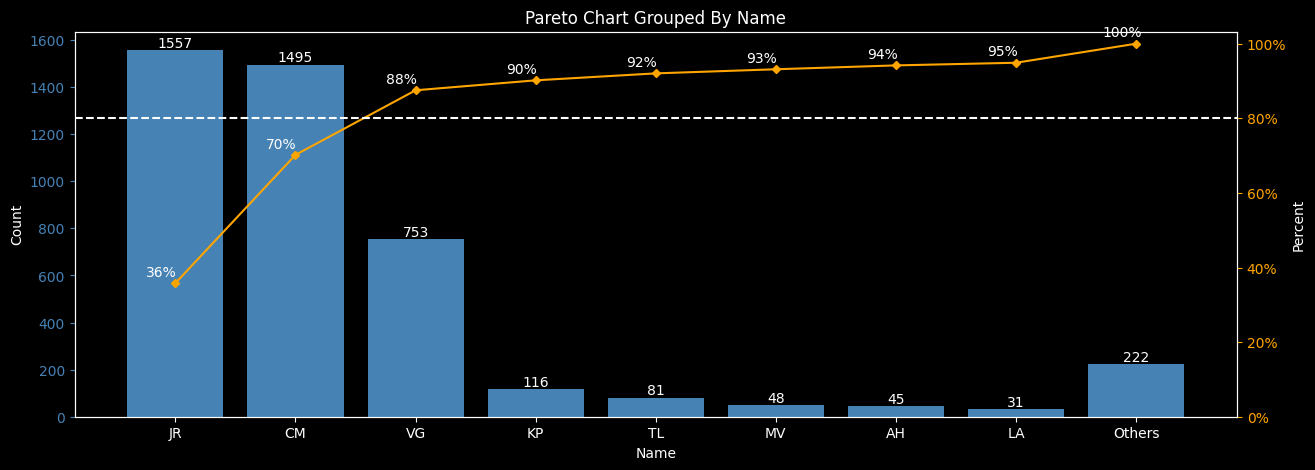

In [576]:
df_grouped = group_count(ridership_df_clean,"name",30)
pareto_chart(df_grouped)

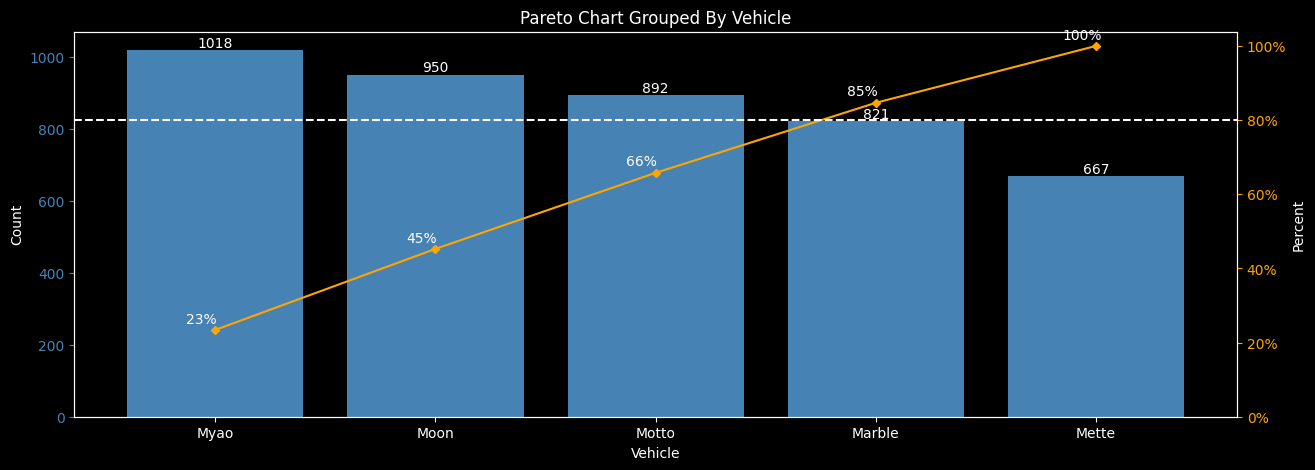

In [577]:
df_grouped = group_count(ridership_df_clean,"vehicle")
pareto_chart(df_grouped)

In [578]:
df_grouped

,freq,cumsum
vehicle,,
Myao,1018,23.41
Moon,950,45.26
Motto,892,65.78
Marble,821,84.66
Mette,667,100.00


In [ ]:
# sns.histplot(data=ridership_df_clean,x="vehicle")
# sns.histplot(data=ridership_df_clean,x="name")

In [ ]:
sns.catplot(data=tips, kind="swarm", x="day", y="total_bill", hue="smoker")

# Prep Data for Machine Learning

## One-Hot Encoding

# Machine Learning I

# Machine Learning II